Train shape: (2855, 25)
Test shape: (8493, 25)


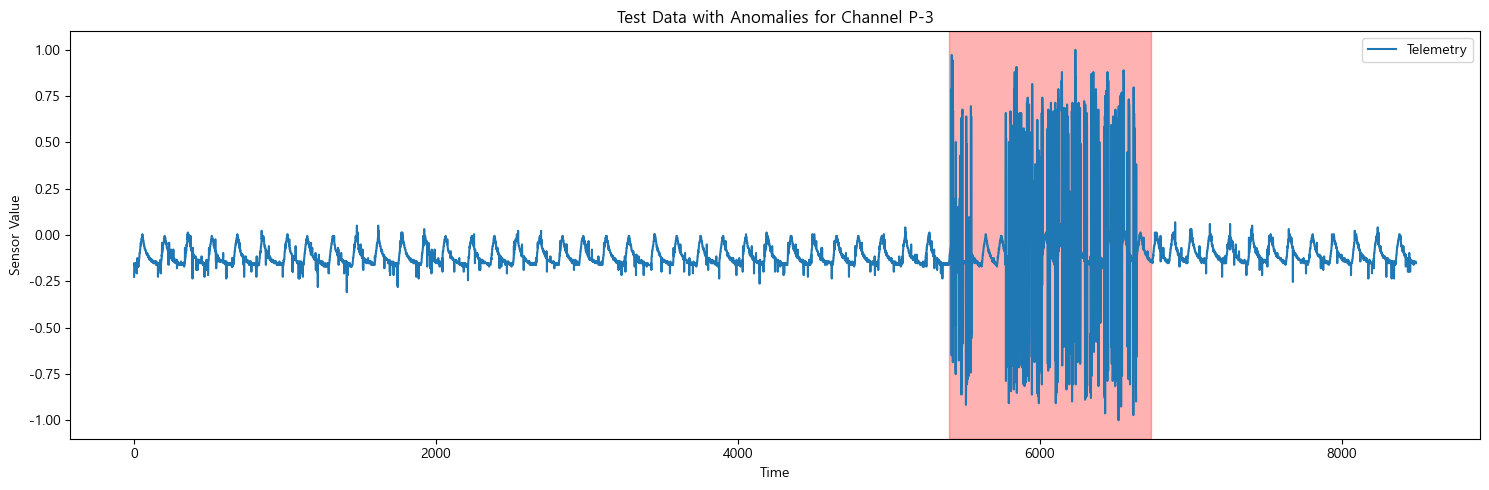

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#  데이터 불러오기
train = np.load("dataset/data/data/train/P-3.npy")
test = np.load("dataset/data/data/test/P-3.npy")

#  라벨 데이터 불러오기
labels = pd.read_csv("dataset/labeled_anomalies.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

#  예측 대상이 되는 첫 번째 컬럼 (실제 센서 값)
train_target = train[:, 0]
test_target = test[:, 0]

#  해당 채널에 대한 이상 구간 가져오기
channel_id = "P-3"
anomalies = labels[labels["chan_id"] == channel_id]["anomaly_sequences"].values

#  이상 구간 분석
import ast
anomaly_ranges = ast.literal_eval(anomalies[0]) if len(anomalies) > 0 else []

#  시각화
plt.figure(figsize=(15,5))
plt.plot(test_target, label='Telemetry')

for (start, end) in anomaly_ranges:
    plt.axvspan(start, end, color='red', alpha=0.3)

plt.title(f"Test Data with Anomalies for Channel {channel_id}")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.tight_layout()
plt.show()


c:\AI_project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0726 - val_loss: 0.0038
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 0.0021 - val_loss: 0.0018
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


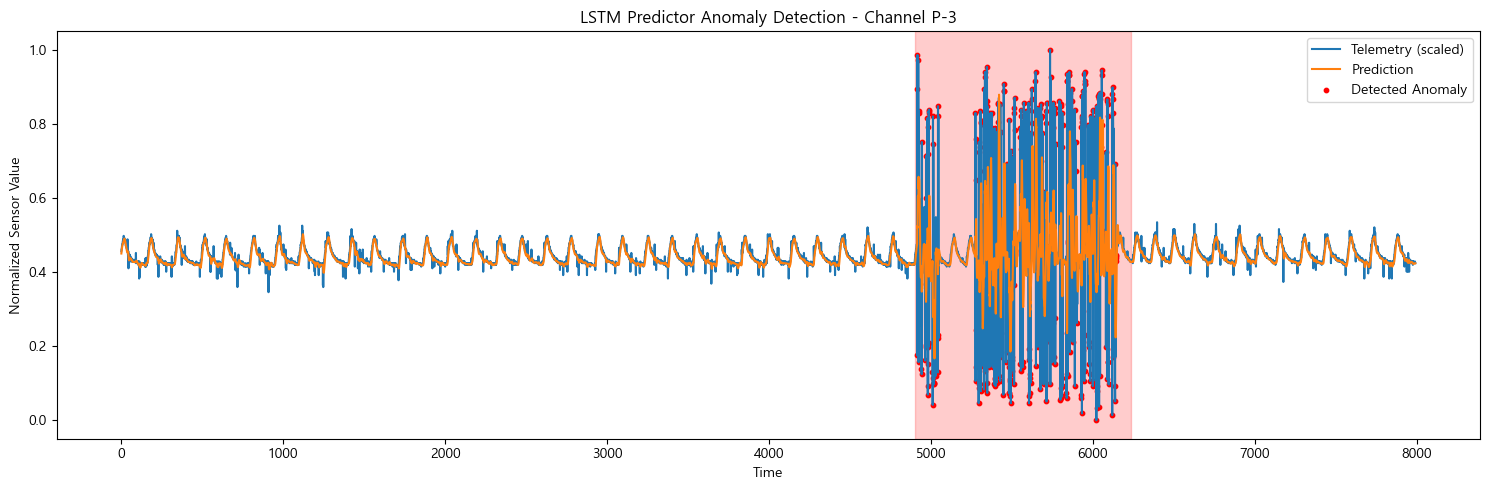

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib
# 하이퍼파라미터
SEQ_LEN = 500 # 시퀀스길이
EPOCHS = 10 #epoch 값
THRESHOLD_STD = 3  #임계값을 표준편차*3으로 정의

# 1. 데이터 불러오기
train = np.load("dataset/data/data/train/P-3.npy")[:, 0].reshape(-1, 1)
test = np.load("dataset/data/data/test/P-3.npy")[:, 0].reshape(-1, 1)
labels = pd.read_csv("dataset/labeled_anomalies.csv")
channel_id = "P-3"

# 2. 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# 3. 시퀀스 생성 함수
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# 4. LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LEN, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# 5. 모델 학습
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.1)
joblib.dump(model,'test_model.pkl')

# 6. 테스트 데이터 예측
y_pred = model.predict(X_test)
errors = np.abs(y_pred - y_test).flatten()

# 임계값 설정 (학습 오차 평균 + n * 표준편차)
train_pred = model.predict(X_train)
train_errors = np.abs(train_pred - y_train).flatten()
threshold = np.mean(train_errors) + THRESHOLD_STD * np.std(train_errors)

# 이상 탐지 결과
anomalies = np.where(errors > threshold)[0]

# 실제 라벨 파싱
import ast
anomaly_ranges = ast.literal_eval(labels[labels["chan_id"] == channel_id]["anomaly_sequences"].values[0])

# 10. 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_scaled[SEQ_LEN:], label="Telemetry (scaled)")
plt.plot(y_pred, label="Prediction")
plt.scatter(anomalies, test_scaled[SEQ_LEN:][anomalies], color='red', label='Detected Anomaly', s=10)

for (start, end) in anomaly_ranges:
    plt.axvspan(start - SEQ_LEN, end - SEQ_LEN, color='red', alpha=0.2)

# plt.axhline(threshold, color='gray', linestyle='--', label='Threshold (error)')
plt.title(f"LSTM Predictor Anomaly Detection - Channel {channel_id}")
plt.xlabel("Time")
plt.ylabel("Normalized Sensor Value")
plt.legend()
plt.tight_layout()
plt.show()


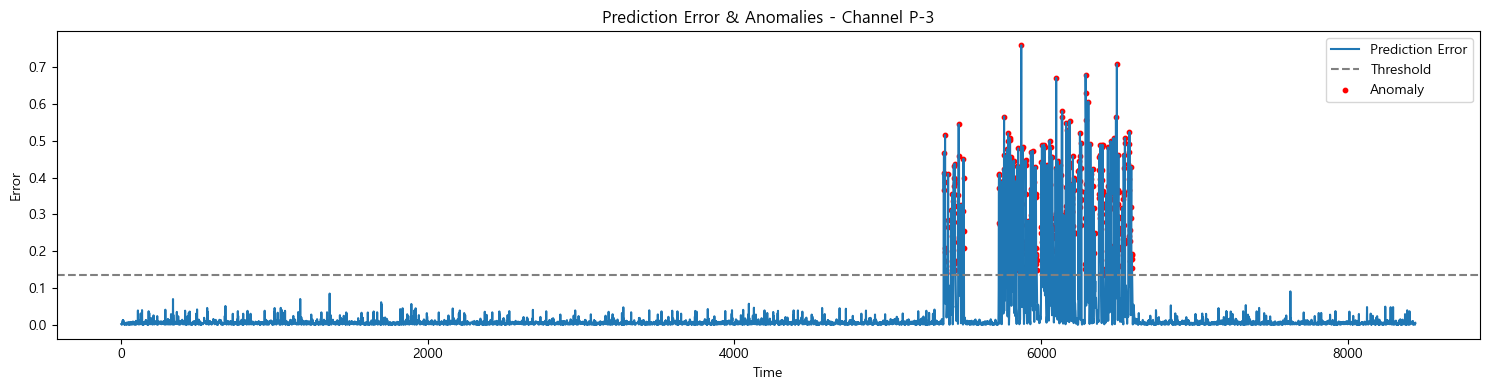

In [15]:
# 예측 오차 시각화
plt.figure(figsize=(15, 4))
plt.plot(errors, label='Prediction Error')
plt.axhline(threshold, color='gray', linestyle='--', label='Threshold')
plt.scatter(anomalies, errors[anomalies], color='red', label='Anomaly', s=10)
plt.title(f'Prediction Error & Anomalies - Channel {channel_id}')
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.tight_layout()
plt.show()


Data shape: (8493, 25)


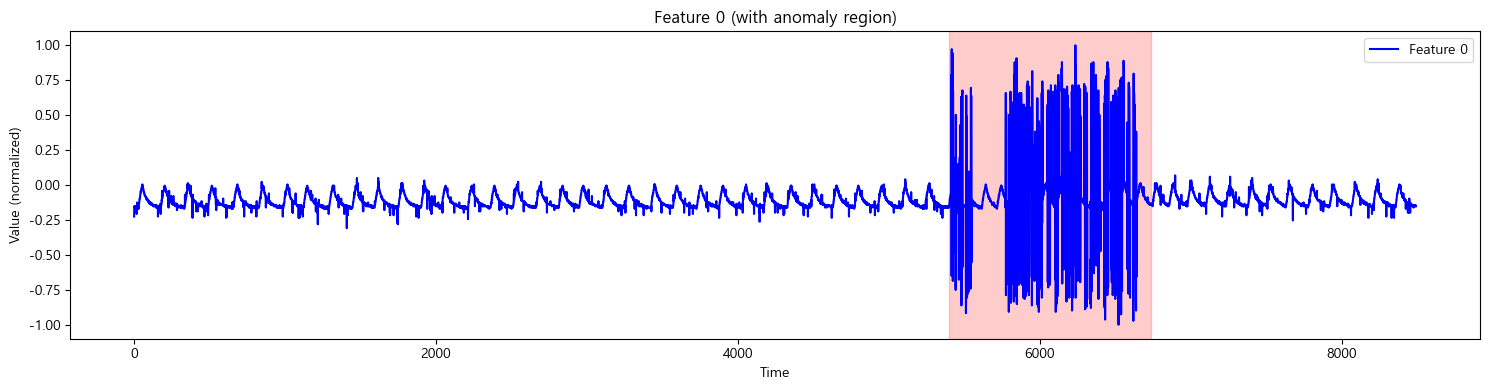

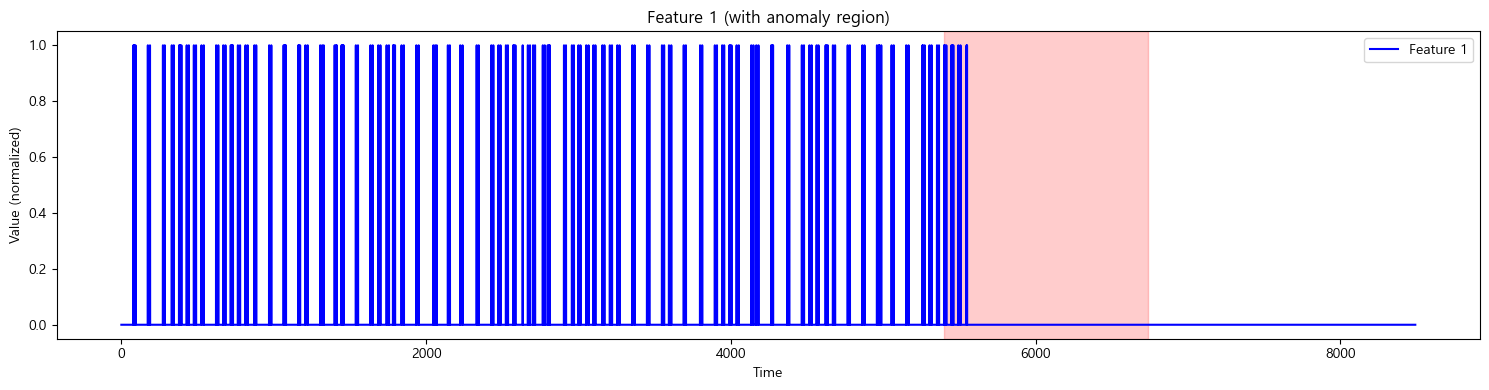

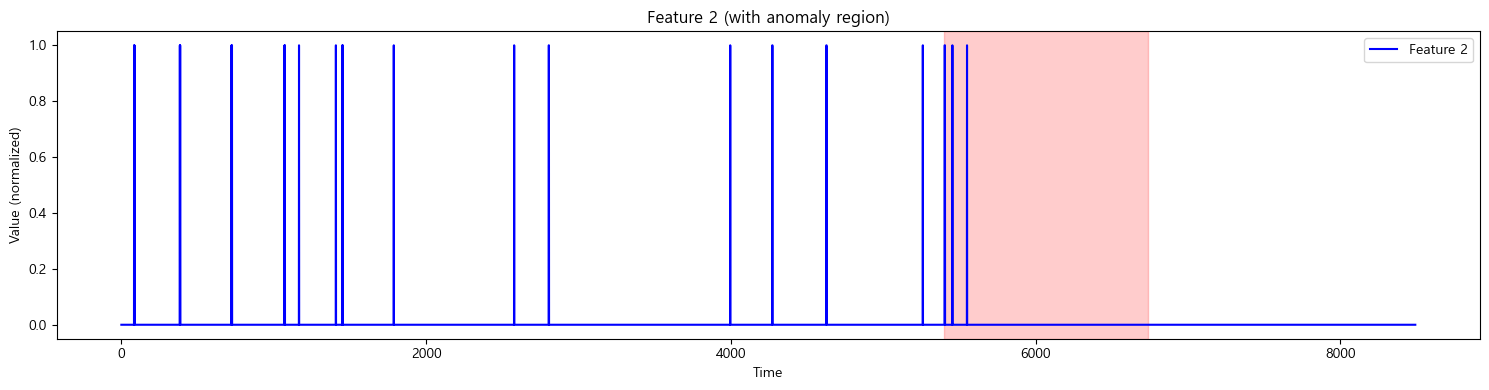

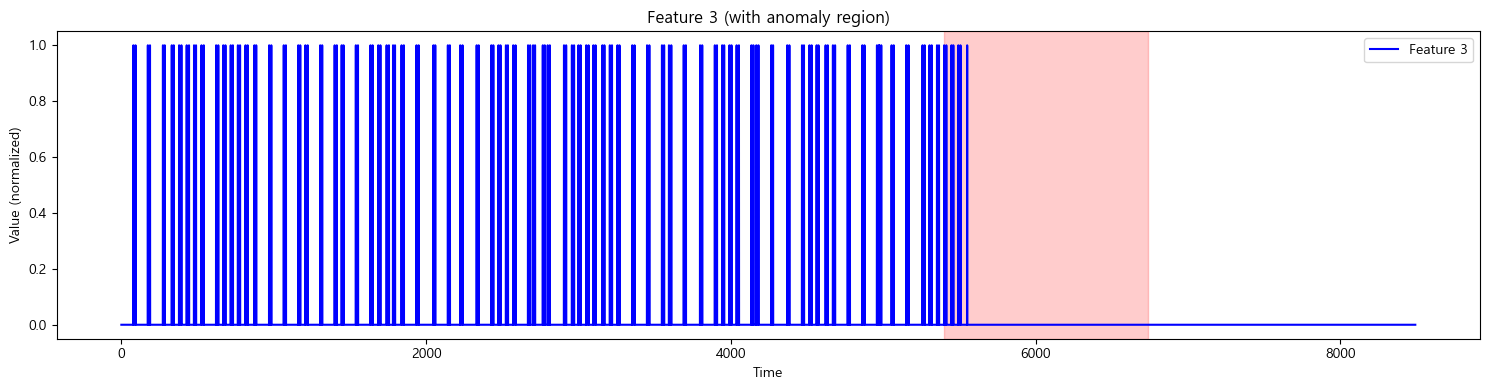

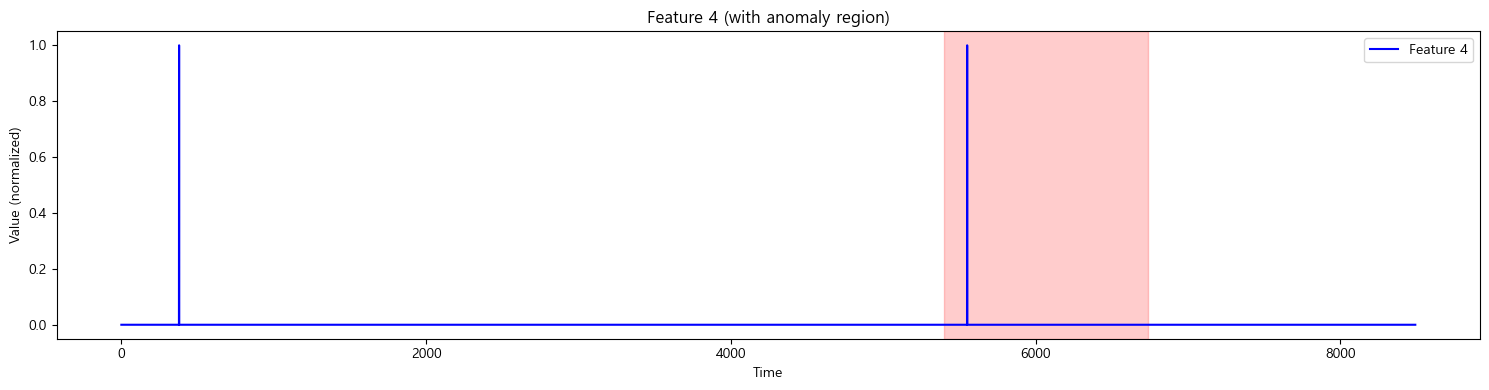

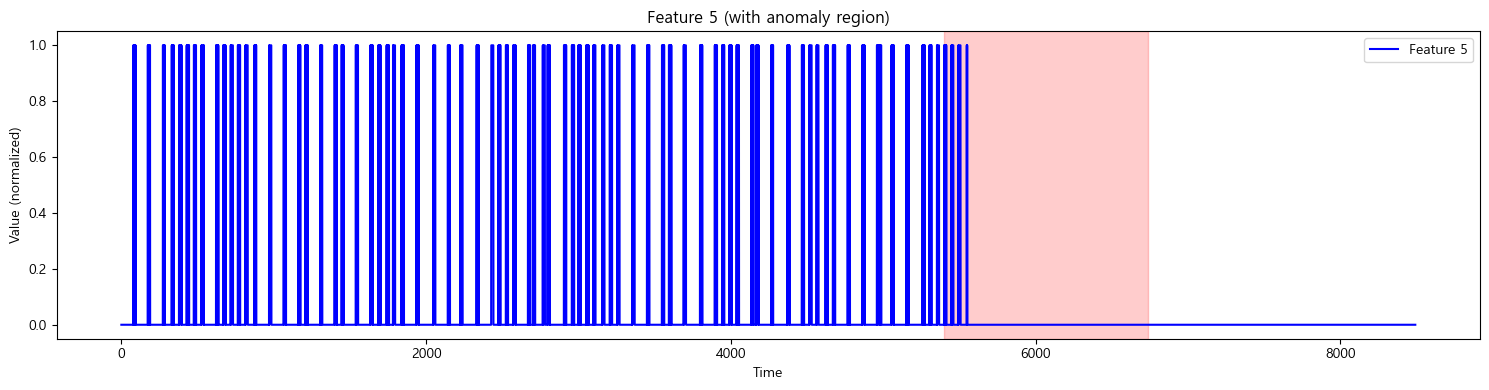

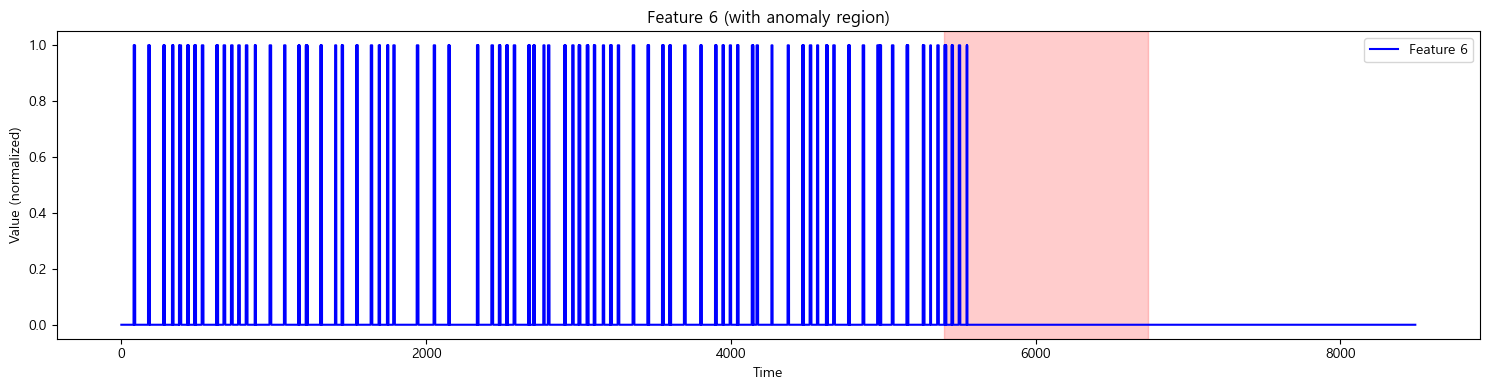

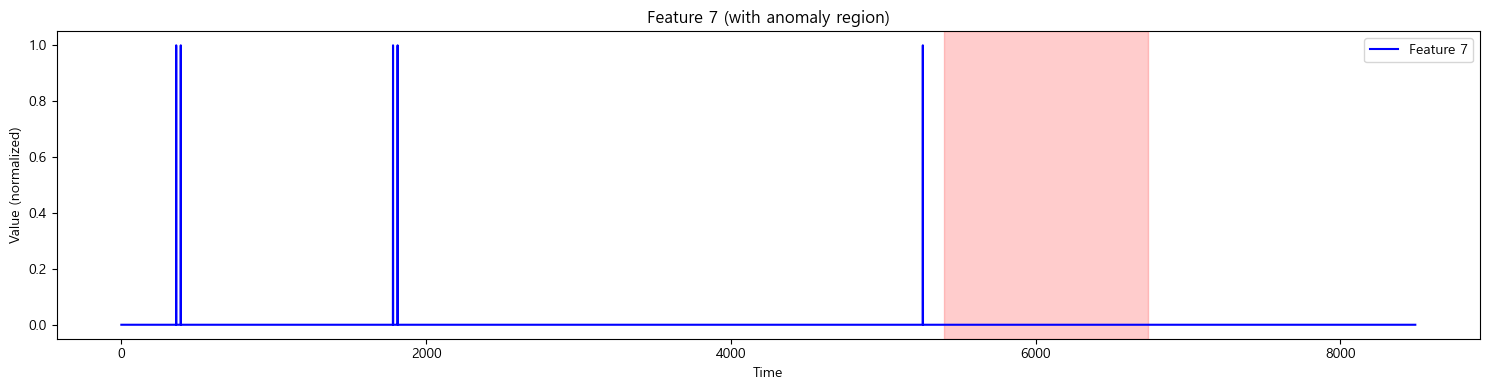

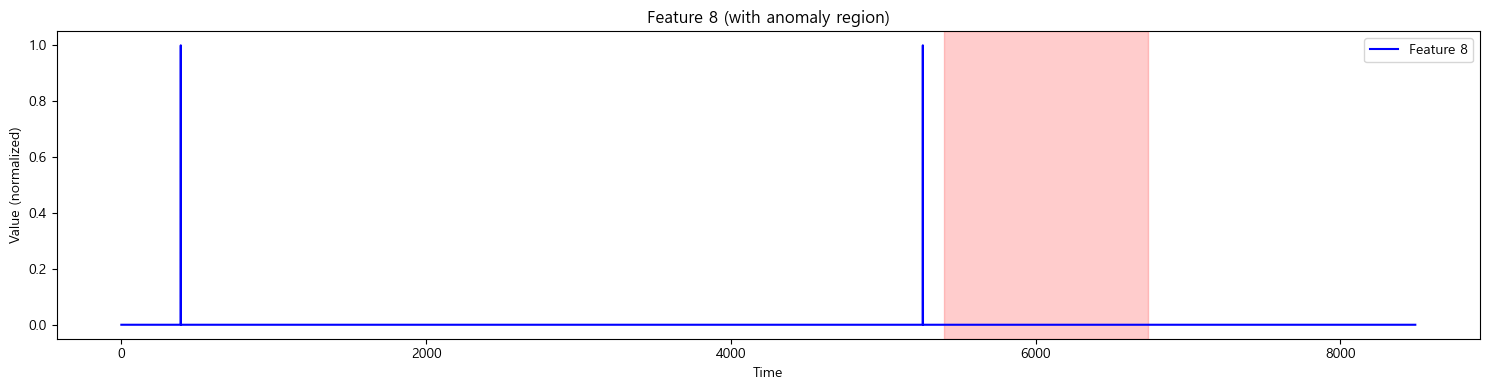

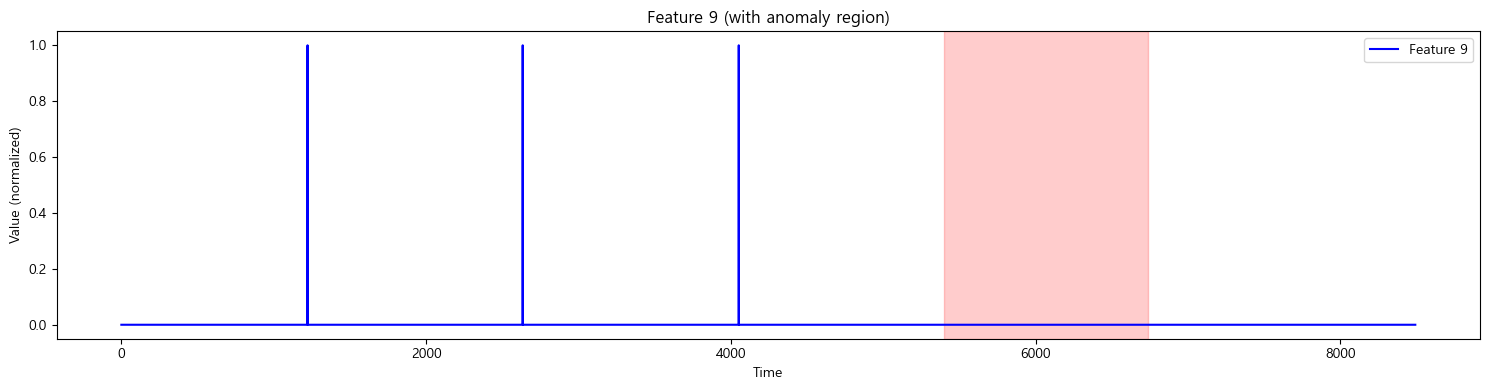

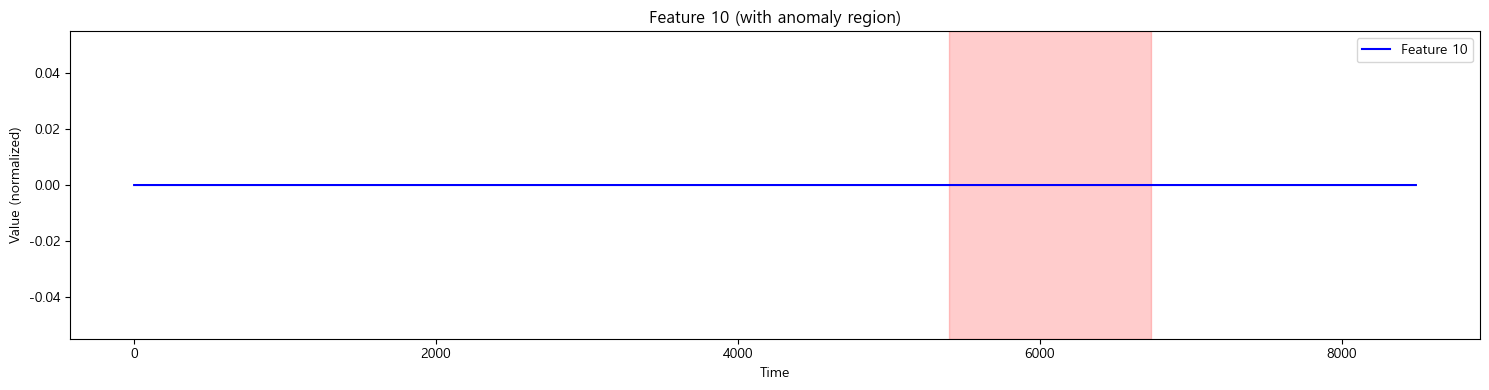

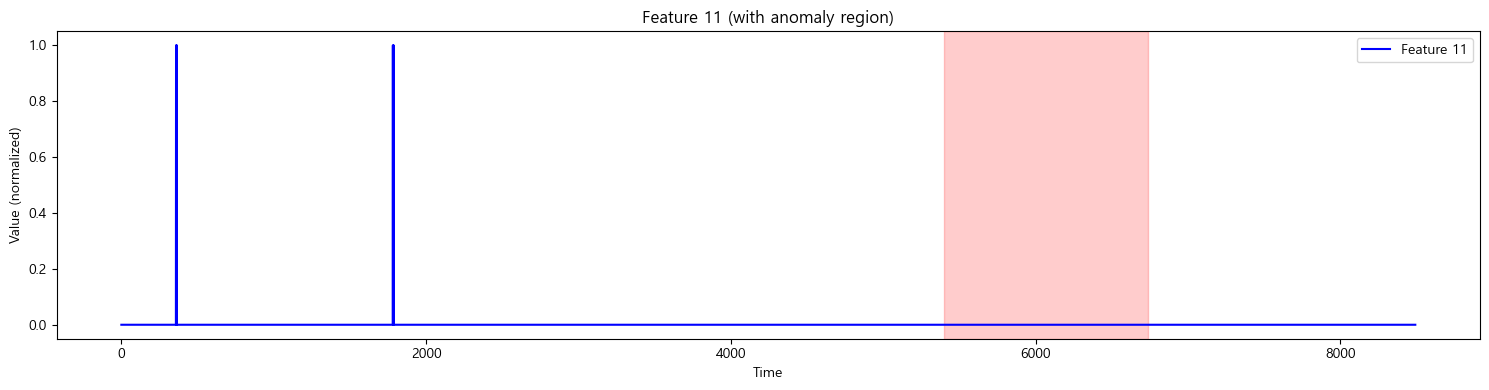

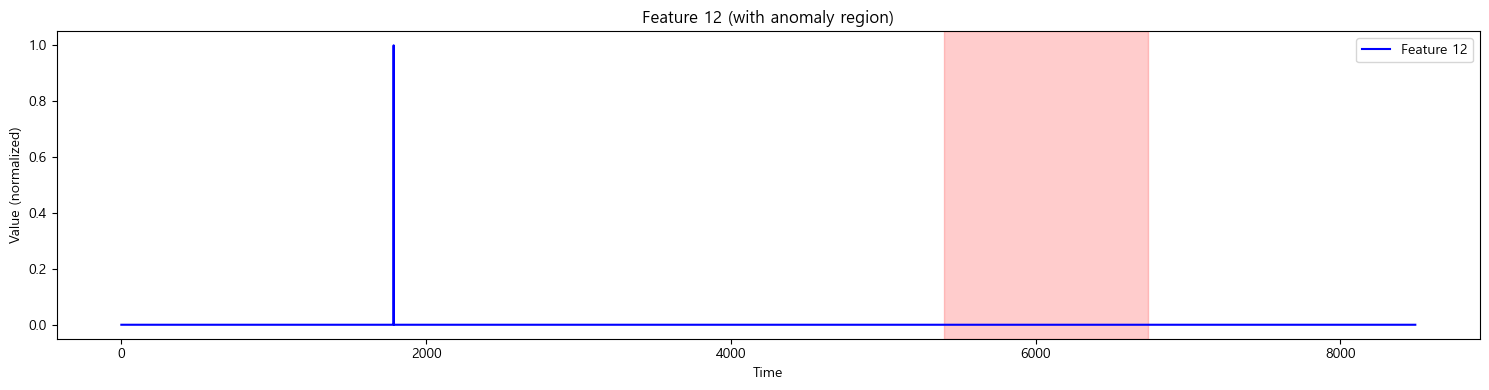

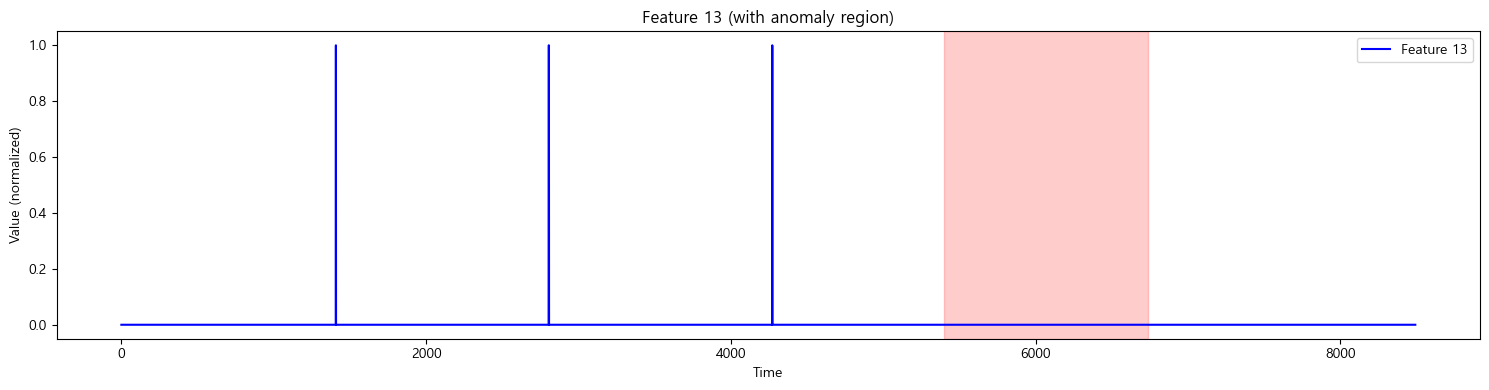

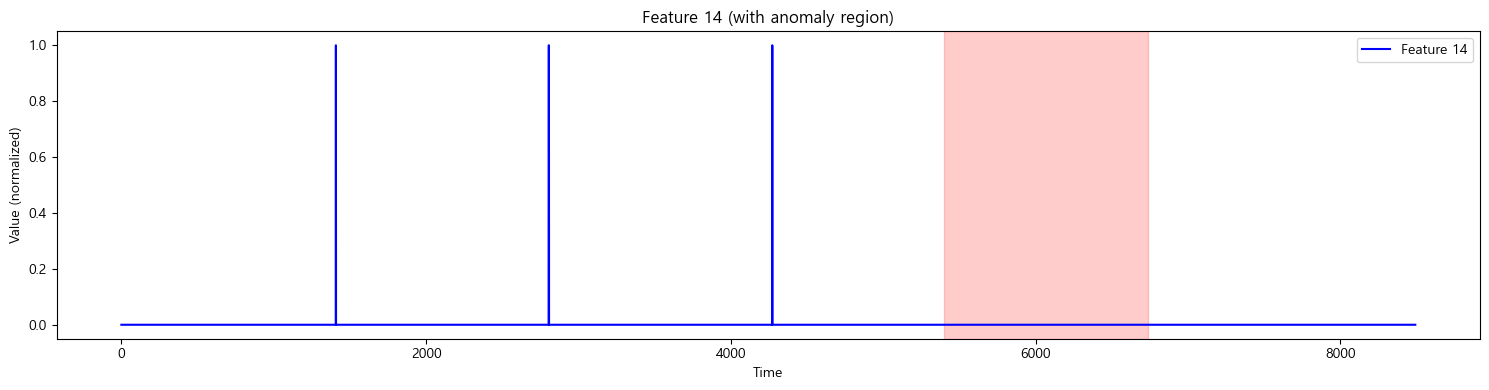

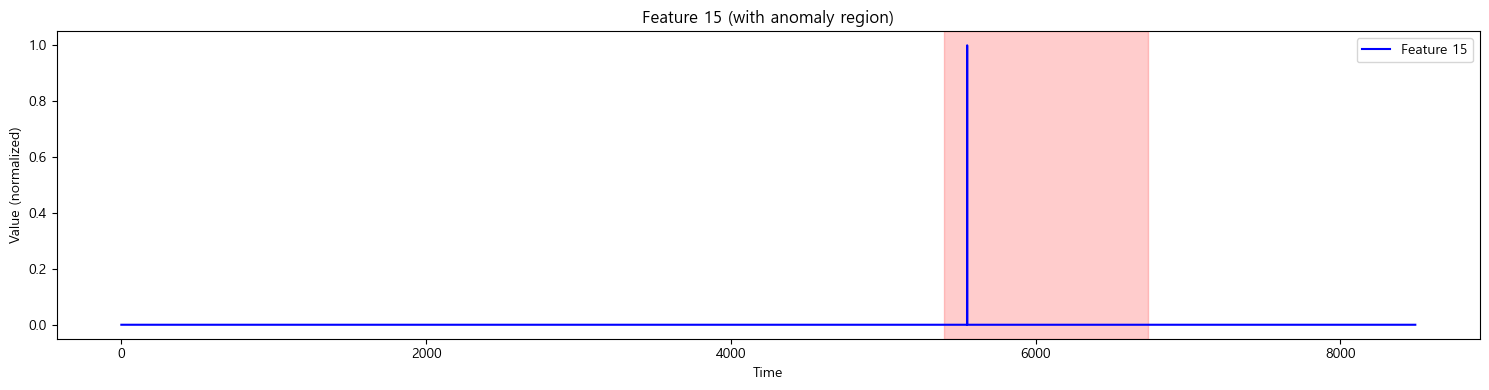

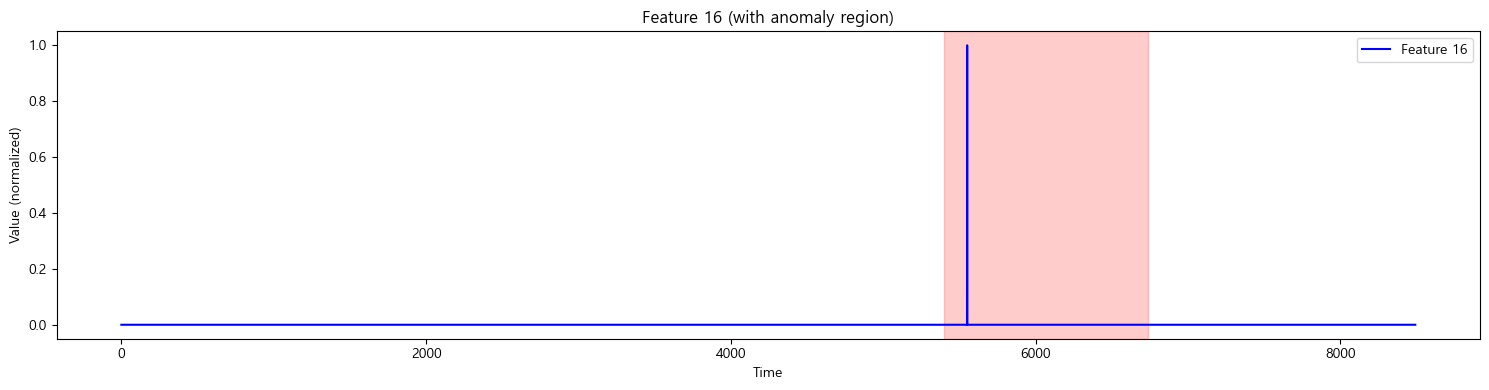

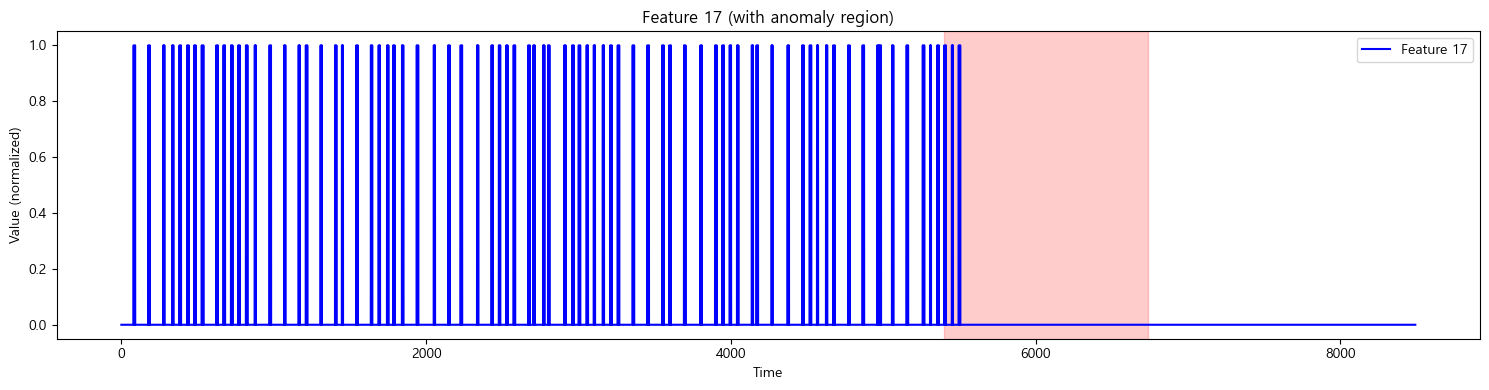

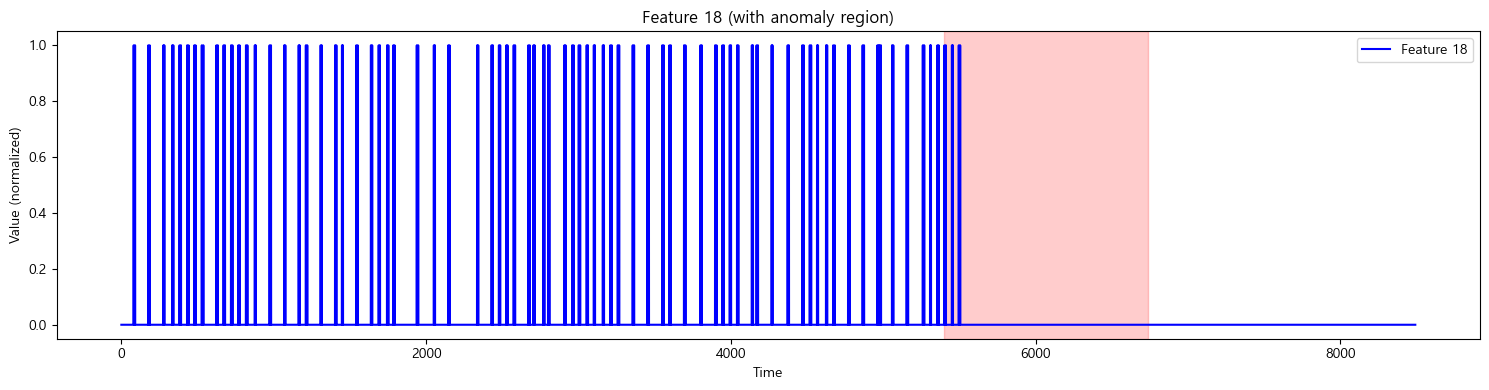

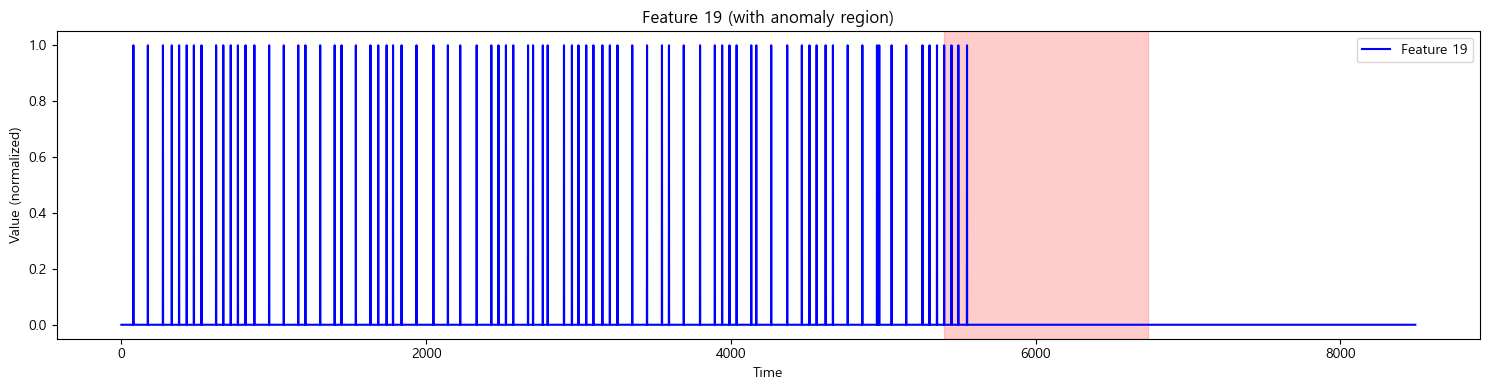

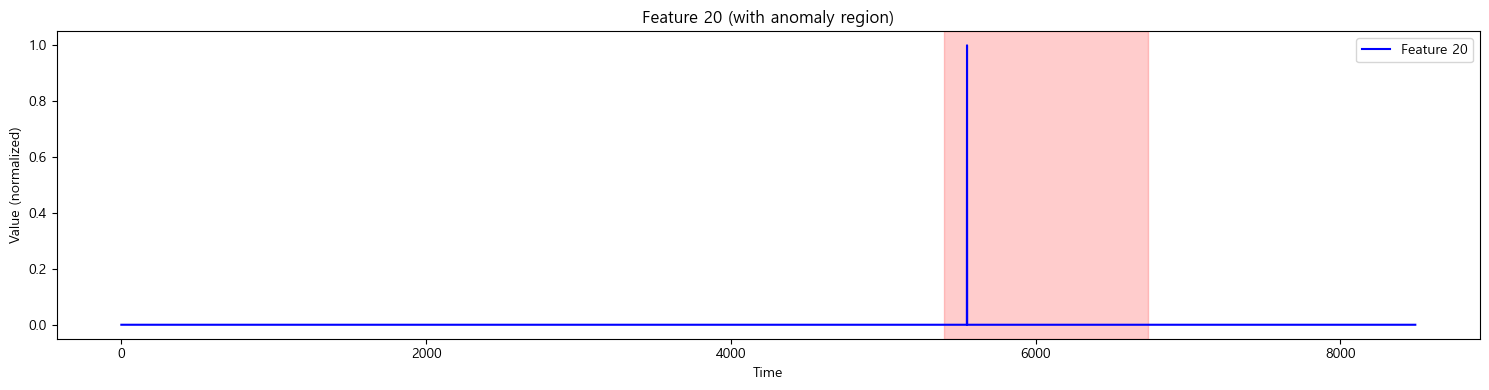

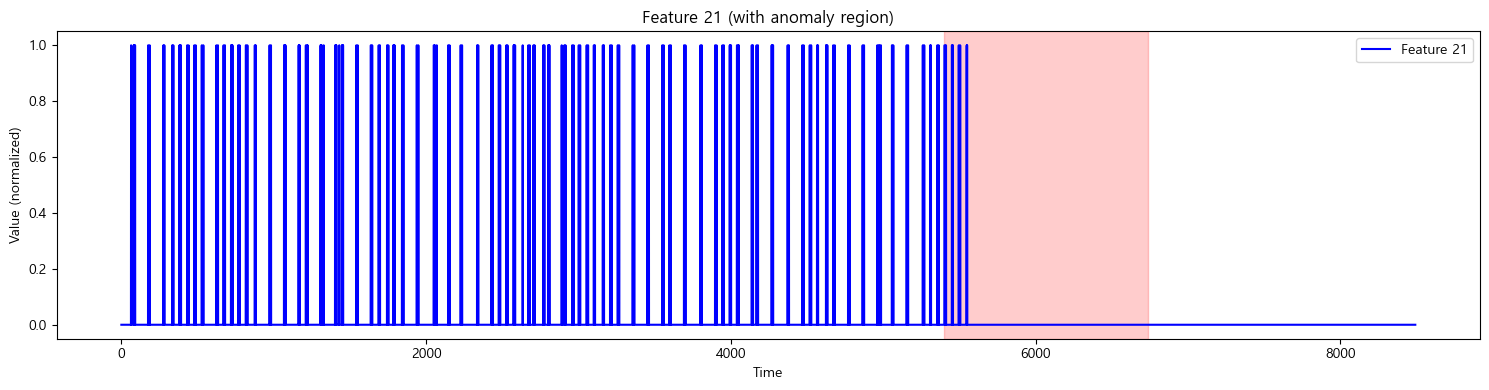

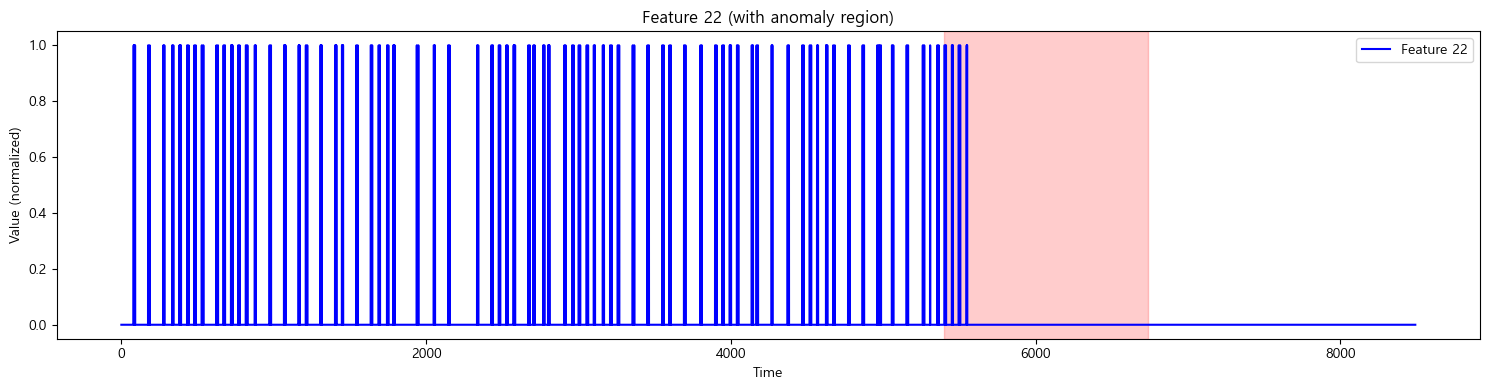

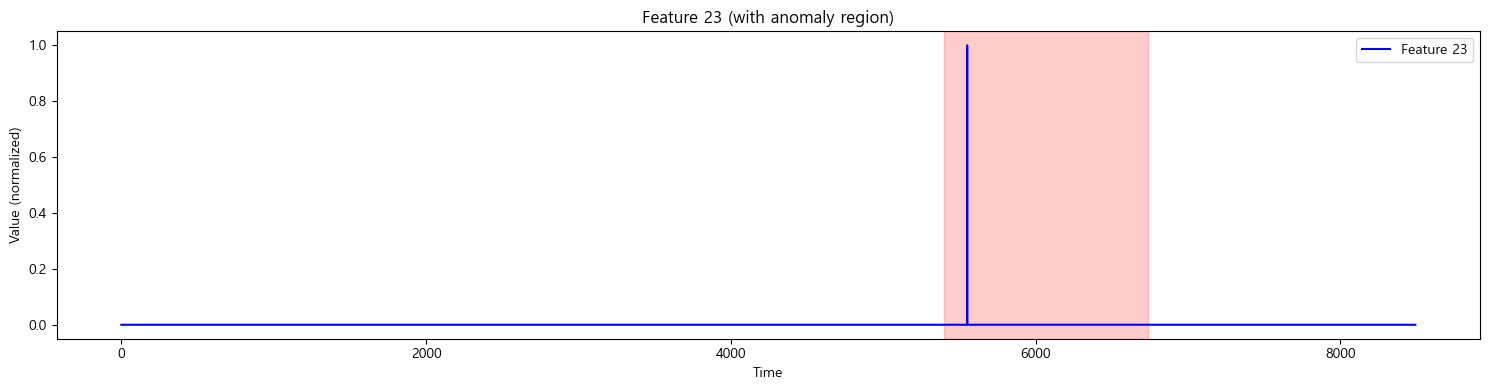

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

# 1. 데이터 불러오기
data = np.load("dataset/data/data/test/P-3.npy")  # (n_timesteps, n_features)
print("Data shape:", data.shape)

# 2. 라벨 불러오기
labels = pd.read_csv("dataset/labeled_anomalies.csv")
channel_id = "P-3"
anomaly_ranges = ast.literal_eval(
    labels[labels["chan_id"] == channel_id]["anomaly_sequences"].values[0]
)

# 3. 시각화 함수
def plot_feature_with_anomaly(feature_index):
    plt.figure(figsize=(15, 4))
    plt.plot(data[:, feature_index], label=f"Feature {feature_index}", color='blue')

    for (start, end) in anomaly_ranges:
        plt.axvspan(start, end, color="red", alpha=0.2)

    plt.title(f"Feature {feature_index} (with anomaly region)")
    plt.xlabel("Time")
    plt.ylabel("Value (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. 예: 0번째 ~ 4번째 특성 확인
for i in range(24):
    plot_feature_with_anomaly(i)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.0020 - val_loss: 0.0017


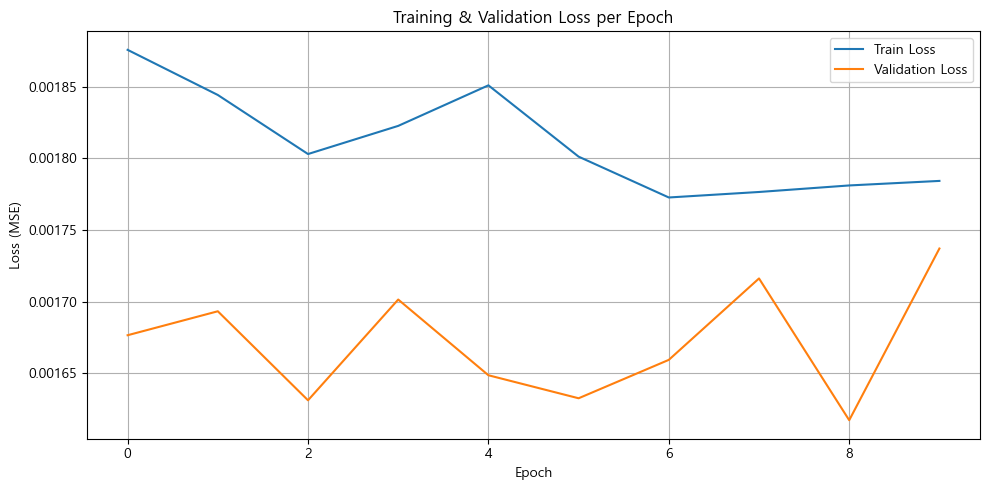

In [25]:
# 모델 학습 (히스토리 저장)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

# 에포크에 따른 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\AI_project\.venv\lib\site-packages\scipy\stats\_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


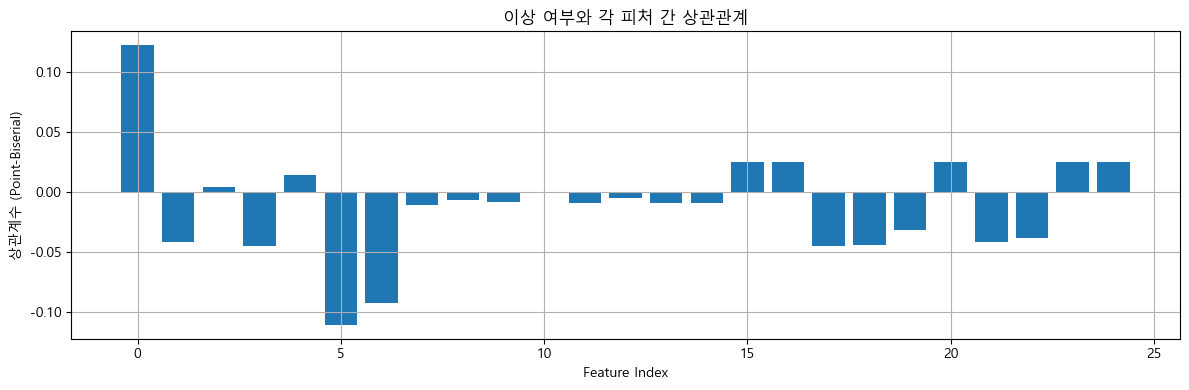

Feature 0의 상관계수: 0.12251233430249336
Feature 5의 상관계수: -0.11074917178505264


In [6]:

from scipy.stats import pointbiserialr

# 타겟 시퀀스 만들기 (전체 시계열 길이만큼 0으로 초기화 후, 이상 구간만 1로)
target = np.zeros(data.shape[0])
for start, end in anomaly_ranges:
    target[start:end] = 1  # 이상 구간은 1로 표시

# 각 피처와 타겟 간 상관관계 계산
correlations = []
for i in range(data.shape[1]):
    corr, _ = pointbiserialr(target, data[:, i])
    correlations.append(corr)

# 시각화
plt.figure(figsize=(12, 4))
plt.bar(range(len(correlations)), correlations)
plt.xlabel("Feature Index")
plt.ylabel("상관계수 (Point-Biserial)")
plt.title("이상 여부와 각 피처 간 상관관계")
plt.grid(True)
plt.tight_layout()
plt.show()
print("Feature 0의 상관계수:", correlations[0])
print("Feature 5의 상관계수:", correlations[5])



In [ ]:
import numpy as np
import pandas as pd
import ast
from ydata_profiling import ProfileReport
import os

#  파일 경로 및 저장 폴더 설정
channel_id = "P-3"
data_path = f"dataset/data/data/test/{channel_id}.npy"
label_path = "dataset/labeled_anomalies.csv"
output_dir = "report"
os.makedirs(output_dir, exist_ok=True)

#  데이터 불러오기
data = np.load(data_path)
df = pd.DataFrame(data)
df.columns = [f"Feature_{i}" for i in range(df.shape[1])]
df["time"] = range(len(df))  # 시간 인덱스 추가

#  타겟(이상 여부) 생성
labels = pd.read_csv(label_path)
anomaly_ranges = ast.literal_eval(labels[labels["chan_id"] == channel_id]["anomaly_sequences"].values[0])
df["anomaly"] = 0
for start, end in anomaly_ranges:
    df.loc[start:end, "anomaly"] = 1

#  프로파일링 리포트 생성
profile = ProfileReport(df, title=f"{channel_id} 이상 탐지 EDA 리포트", explorative=True)

#  리포트 저장
output_file = f"{output_dir}/{channel_id}_anomaly_report.html"
profile.to_file(output_file)

print(f" 리포트 생성 완료! 경로: {output_file}")


c:\AI_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 125.09it/s]

✅ 리포트 생성 완료! 경로: report/P-3_anomaly_report.html


In [41]:
def check_point_status(time):

    # 예측 오차 기준
    adjusted_index = time - SEQ_LEN

    # 모델 기준: 오차가 threshold 초과했는지 확인
    model_is_anomaly = errors[adjusted_index] > threshold

    # 실제 라벨 기준: 이 시점이 이상 구간 안에 포함되는지 확인
    label_is_anomaly = any(start <= time <= end for (start, end) in anomaly_ranges)

    # 결과 출력
    print(f" 검사 시점: {time}초")
    print(f" - 모델 판단: {'이상치' if model_is_anomaly else '정상'}")
    print(f" - 실제 라벨: {'이상치' if label_is_anomaly else '정상'}")
    print(f" - 일치여부 : {'정답' if label_is_anomaly==model_is_anomaly else '오답'}")
    return model_is_anomaly, label_is_anomaly

check_point_status(6000)  # 시간입력시 모델과 실제값 비교


 검사 시점: 6000초
 - 모델 판단: 이상치
 - 실제 라벨: 이상치
 - 일치여부 : 정답


(np.True_, True)

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step
▶ 검사 시점: 6000 (SEQ_LEN: 500)
 - 모델 판단: 🛑 이상치
 - 실제 라벨: 🛑 이상치
 - 일치 여부 : 🎯 정답


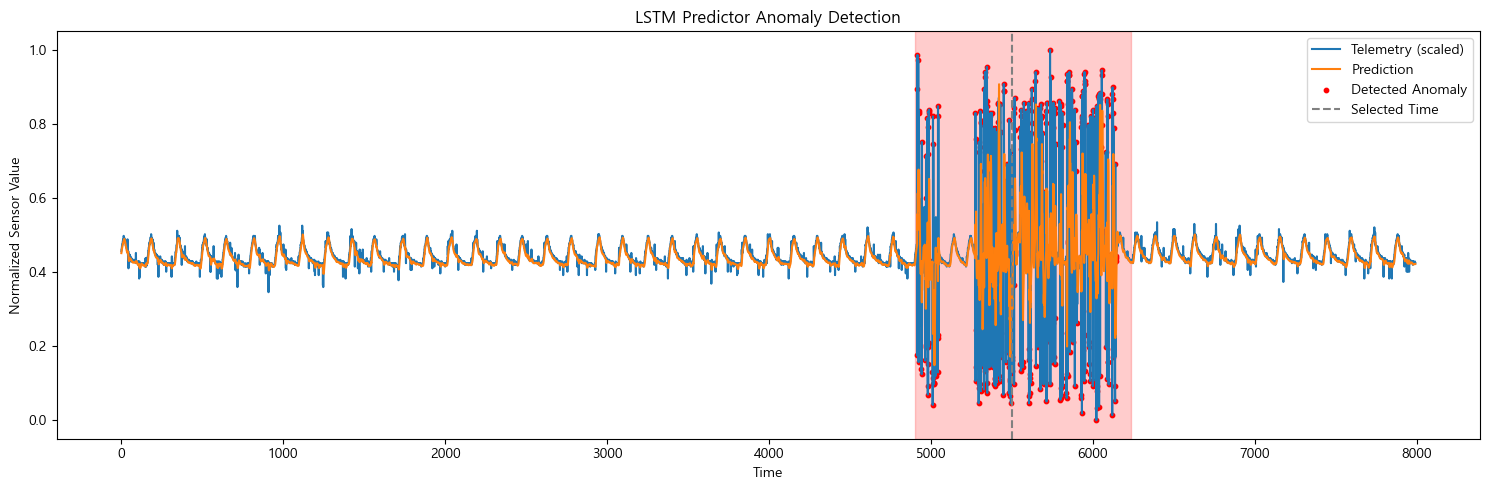

(np.True_, True)

In [ ]:
import matplotlib.pyplot as plt

def check_point_status(index, errors, threshold, anomaly_ranges, y_test, y_pred, seq_len=50, show_plot=True, verbose=True):
    """
    특정 시점에 대한 이상 여부 판단 + 그래프 출력

    index: 검사할 시점 (원본 시계열 인덱스 기준)
    show_plot: True면 그래프 출력
    verbose: True면 텍스트 출력
    """

    adjusted_index = index - seq_len

    if adjusted_index < 0 or adjusted_index >= len(errors):
        if verbose:
            print(f" 검사 시점 {index}은 유효하지 않습니다.")
        return None, None

    model_is_anomaly = errors[adjusted_index] > threshold
    label_is_anomaly = any(start <= index <= end for (start, end) in anomaly_ranges)

    if verbose:
        print(f"▶ 검사 시점: {index} (SEQ_LEN: {seq_len})")
        print(f" - 모델 판단: {' 이상치' if model_is_anomaly else ' 정상'}")
        print(f" - 실제 라벨: {' 이상치' if label_is_anomaly else ' 정상'}")
        print(f" - 일치 여부 : {' 정답' if label_is_anomaly == model_is_anomaly else ' 오답'}")

    if show_plot:
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(y_test, label="Telemetry (scaled)")
        ax.plot(y_pred, label="Prediction")
        ax.scatter(
            np.where(errors > threshold)[0],
            y_test[errors > threshold],
            color="red",
            label="Detected Anomaly",
            s=10,
        )

        for (start, end) in anomaly_ranges:
            ax.axvspan(start - seq_len, end - seq_len, color="red", alpha=0.2)

        ax.axvline(index - seq_len, color="gray", linestyle="--", label="Selected Time")
        ax.set_title("LSTM Predictor Anomaly Detection")
        ax.set_xlabel("Time")
        ax.set_ylabel("Normalized Sensor Value")
        ax.legend()
        plt.tight_layout()
        plt.show()

    return model_is_anomaly, label_is_anomaly
check_point_status(
    6000, 
    errors=errors, 
    threshold=threshold, 
    anomaly_ranges=anomaly_ranges, 
    y_test=y_test, 
    y_pred=model.predict(X_test), 
    seq_len=SEQ_LEN
)


In [46]:
# 예측값
y_pred = model.predict(X_test)

# 원본 기준 x축 인덱스 생성
x_range = np.arange(SEQ_LEN, SEQ_LEN + len(y_test))  # X_test, y_test 기준 인덱스

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x_range, test[SEQ_LEN:], label="Telemetry (original)")
ax.plot(x_range, y_pred, label="Prediction")

# 이상치 포인트 시각화
anomaly_idx = np.where(errors > threshold)[0]
ax.scatter(
    x_range[anomaly_idx],
    test[SEQ_LEN:][anomaly_idx],
    color="red",
    label="Detected Anomaly",
    s=10
)

# 실제 이상 범위 표시 (원본 인덱스 그대로 사용!)
for (start, end) in anomaly_ranges:
    ax.axvspan(start, end, color="red", alpha=0.2)

# 선택 시점 표시
ax.axvline(point_index, color='red', linestyle='--', label='Selected Time')

ax.set_title(f"LSTM Predictor Anomaly Detection - Channel {channel_id}")
ax.set_xlabel("Time")
ax.set_ylabel("Sensor Value")
ax.legend()
plt.tight_layout()

st.pyplot(fig)


250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step


ValueError: x and y must have same first dimension, but have shapes (7993,) and (8443, 1)

In [33]:
import streamlit as st
import matplotlib as plt
import joblib
st.title('이상치 판단 모델')
st.write('이상치를 판단하고 실제 결과와 비교해보세요!')

2025-03-25 10:38:24.680 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 10:38:25.055 
  command:

    streamlit run c:\AI_project\.venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-25 10:38:25.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 10:38:25.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 10:38:25.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 10:38:25.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 10:38:25.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [49]:
# 예측값
y_pred = model.predict(X_test)

# 시각화용 x축 생성
x_range = np.arange(SEQ_LEN, SEQ_LEN + len(y_test))  # 50 ~ 8043

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x_range, test_scaled[SEQ_LEN:], label="Telemetry (scaled)")
ax.plot(x_range, y_pred, label="Prediction")
ax.scatter(
    x_range[errors > threshold],
    test_scaled[SEQ_LEN:][errors > threshold],
    color="red",
    label="Detected Anomaly",
    s=10
)

# 실제 이상 범위 표시 (원본 인덱스 기준 그대로 사용 가능)
for (start, end) in anomaly_ranges:
    ax.axvspan(start, end, color="red", alpha=0.2)

# 선택 시점
ax.axvline(point_index, color='gray', linestyle='--', label='Selected Time')

ax.set_title(f"LSTM Predictor Anomaly Detection - Channel {channel_id}")
ax.set_xlabel("Time")
ax.set_ylabel("Normalized Sensor Value")
ax.legend()
plt.tight_layout()
st.pyplot(fig)


ValueError: x and y must have same first dimension, but have shapes (7993,) and (8443, 1)

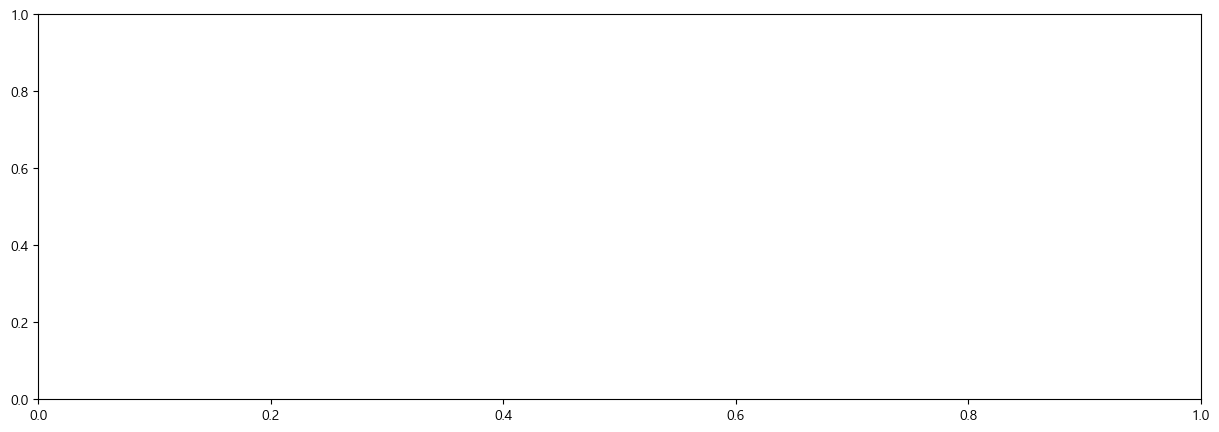

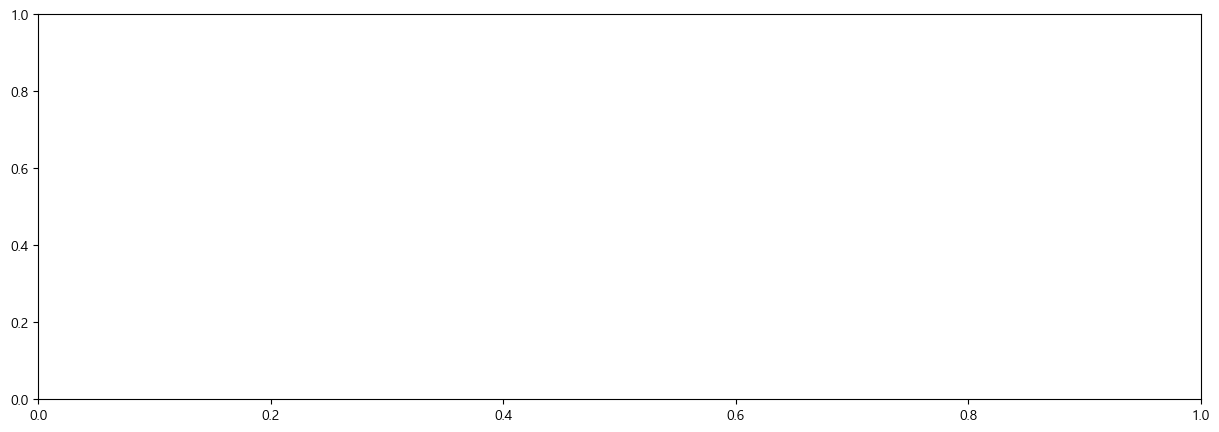

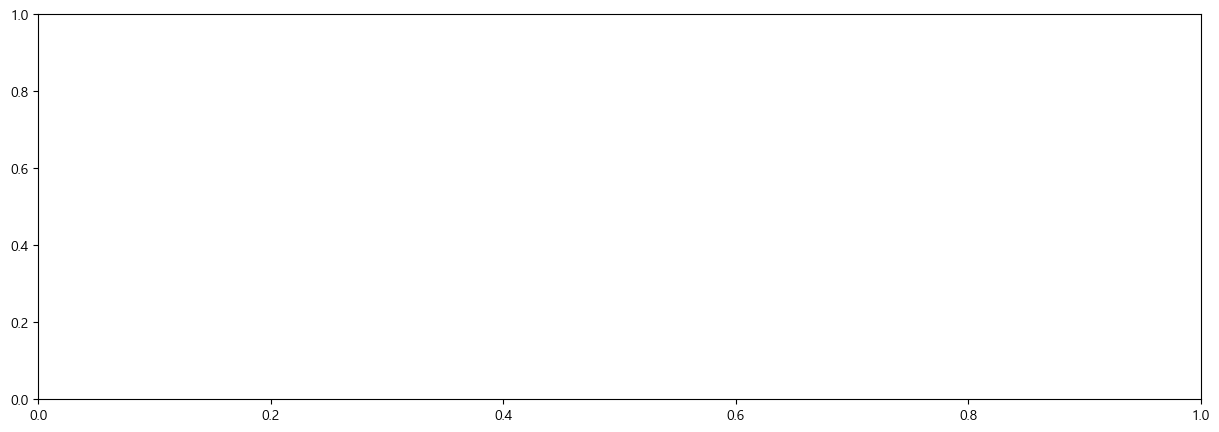

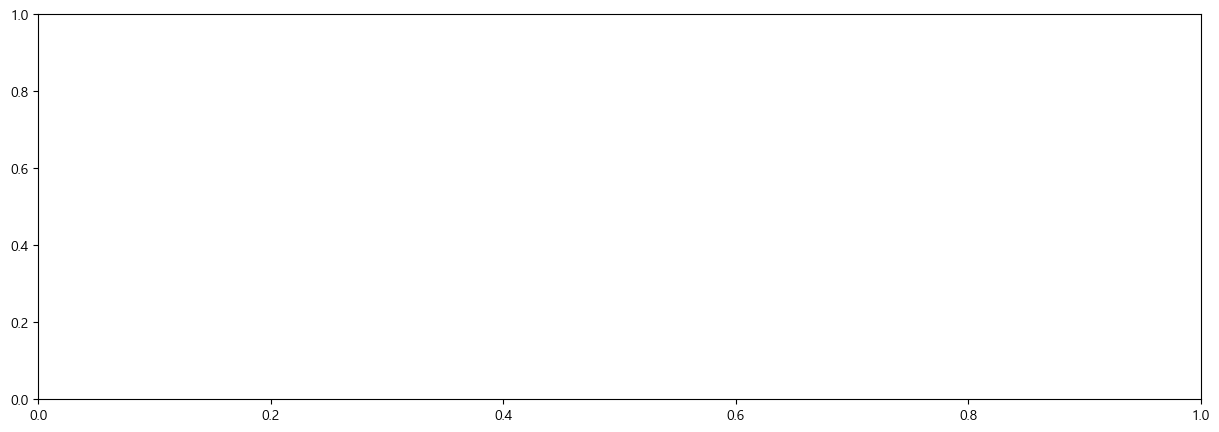

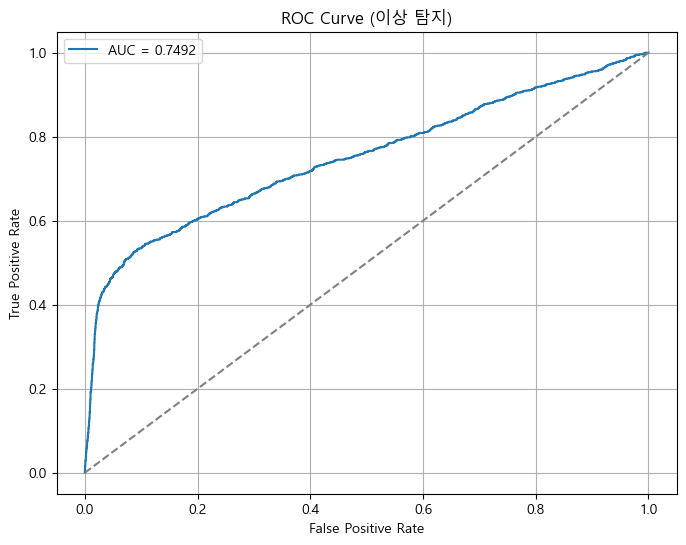

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 1. 실제 이상 여부(y_true) 생성
y_true = np.zeros(len(errors))
for start, end in anomaly_ranges:
    # SEQ_LEN 보정
    start_idx = max(0, start - SEQ_LEN)
    end_idx = max(0, end - SEQ_LEN)
    y_true[start_idx:end_idx] = 1

# 2. ROC 커브 및 AUC 점수 계산
fpr, tpr, thresholds = roc_curve(y_true, errors)
auc_score = roc_auc_score(y_true, errors)

# 3. ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (이상 탐지)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
model.compile(optimizer='adam', loss='mse')
# 모델 학습 완료
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.1)

# 테스트 데이터 예측
y_pred = model.predict(X_test)
errors = np.abs(y_pred - y_test).flatten()

# 임계값 설정
train_pred = model.predict(X_train)
train_errors = np.abs(train_pred - y_train).flatten()
threshold = np.mean(train_errors) + THRESHOLD_STD * np.std(train_errors)
import joblib

save_path = "saved_model/lstm_data_P3.pkl"
joblib.dump({
    "y_test": y_test,
    "y_pred": y_pred,
    "errors": errors,
    "threshold": threshold,
    "scaler": scaler,
    "SEQ_LEN": SEQ_LEN
}, save_path)

print("✅ 이상 탐지 결과가 저장되었습니다:", save_path)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0018 - val_loss: 0.0017
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
✅ 이상 탐지 결과가 저장되었습니다: saved_model/lstm_data_P3.pkl
